In [1]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import numpy as np
from time import time

CUDA = torch.cuda.is_available()

### VAE Model

In [51]:
RAW_DATA_DIR = "../Data/Raw/"
PROCESSED_DATA_DIR = "../Data/Processed/VAE/"

class CovariateDataset(Dataset):
    def __init__(self, file_name_pattern, file_name_args):
        self.file_name = file_name_pattern.format(*file_name_args, "covar")
        self.assignment_file_name = file_name_pattern.format(*file_name_args, "assignment")
        
        self.data = np.loadtxt(RAW_DATA_DIR + self.file_name + ".csv", delimiter=",")[:, 1:] # remove bias
        self.assignment_data = np.loadtxt(RAW_DATA_DIR + self.assignment_file_name + ".csv", delimiter=",")
        
    def __getitem__(self, index):
        return (self.data[index].astype(float), 0)

    def __len__(self):
        return self.data.shape[0]
    
    def save_processed_data(self, data):
        name = PROCESSED_DATA_DIR + self.file_name+".csv"
        np.savetxt(name, data, delimiter=",")

In [3]:
# # Based on an example from https://github.com/pytorch/examples/blob/master/vae/main.py
# # Extended to place a different prior on binary vs normal vars

# SEED = 1

# ZDIMS = 4 # latent dimensions
# INTERMEDIATE_DIMS = 32
# FEATURES = 10
# DIAG_VAR = True

# BINARY = [0, 2, 5, 7, 8]
# NORMAL = [1, 3, 5, 6, 9]

# torch.manual_seed(SEED)
# if CUDA:
#     torch.cuda.manual_seed(SEED)

# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()
        
#         self.relu = nn.ReLU()
        
#         # ENCODER LAYERS
#         self.dense1 = nn.Linear(FEATURES, INTERMEDIATE_DIMS)
#         self.dense2_1 = nn.Linear(INTERMEDIATE_DIMS, ZDIMS)  # mu layer
#         self.dense2_2 = nn.Linear(INTERMEDIATE_DIMS, ZDIMS)  # logvariance layer
        
#         # this last layer bottlenecks through ZDIMS connections

#         # DECODER LAYERS
#         self.dense3 = nn.Linear(ZDIMS, INTERMEDIATE_DIMS)
#         self.dense4 = nn.Linear(INTERMEDIATE_DIMS, FEATURES)

#     def encode(self, x):
#         h1 = self.relu(self.dense1(x))
#         return self.dense2_1(h1), self.dense2_2(h1) #mu, logvar

#     def reparameterize(self, mu, logvar):
#         if self.training:
#             # If we sampled directly from the latent distribution
#             # we wouldn't be able to backprop the results because
#             # there is no clear grad on the distribution

#             # This reparam samples from a unit gaussian and then scales
#             # by the latent parameters giving a defined route to backprop.

#             std = logvar.mul(0.5).exp_() 

#             # Sample from a unit gaussian with dimensions matching
#             # the latent space.
#             eps = Variable(std.data.new(std.size()).normal_())

#             return eps.mul(std).add_(mu) # rescale and return
#         else:
#             return mu

#     def decode(self, z):
#         h3 = self.relu(self.dense3(z))
#         mu_out = self.dense4(h3)# Deleted: self.sigmoid(self.dense4(h3))
        
#         return mu_out

#     def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, FEATURES))
#         z = self.reparameterize(mu, logvar)
#         mu_out = self.decode(z)
#         return mu_out, mu, logvar

# def loss_function(recon_batch_mu, batch_x, mu_latent, logvar_latent):
    
#     # MSE: how good is the reconstruction in terms of
#     mse_loss = nn.MSELoss(size_average=False)
#     recon_loss = mse_loss(recon_batch_mu, batch_x)
    
#     recon_loss /= batch_x.size()[0]
    
#     # KLD is Kullback–Leibler divergence. Regularize VAE by
#     # penalizing divergence from the prior

#     # See Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     KLD = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp())
#     # Normalise by same number of elements as in reconstruction
#     KLD /= batch_x.size()[0] * FEATURES
    
# #     print("RL", recon_loss)
# #     print("KLD", KLD)
#     return recon_loss + KLD

# def train(model, optimizer, epoch, data_loader, log_results=False):
#     model.train()
#     train_loss = 0

#     for batch_idx, (data, _) in enumerate(data_loader):
#         data = Variable(data)
#         data = data.float()
#         if CUDA:
#             data = data.cuda()
        
#         optimizer.zero_grad()

#         recon_data, mu_latent, logvar_latent = model(data)
        
#         # calculate loss
#         loss = loss_function(recon_data, data, mu_latent, logvar_latent)
#         train_loss += loss.data[0]
        
#         # Find the gradient and descend
#         loss.backward()
#         optimizer.step()
        
#     if log_results:
#         print('====> Epoch: {} Average loss: {:.8f}'.format(
#               epoch, train_loss / len(data_loader.dataset)))

In [124]:
# Based on an example from https://github.com/pytorch/examples/blob/master/vae/main.py
# Extended to place a different prior on binary vs normal vars

SEED = 1

ZDIMS = 2 # latent dimensions
INTERMEDIATE_DIMS_1 = 128
INTERMEDIATE_DIMS_2 = 64
INTERMEDIATE_DIMS_3 = 32
FEATURES = 10
DIAG_VAR = True

BINARY = [0, 2, 5, 7, 8]
NORMAL = [1, 3, 5, 6, 9]

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

class ModifiedVAE(nn.Module):
    def __init__(self):
        super(ModifiedVAE, self).__init__()
        
        self.relu = nn.ReLU()
        
        # ENCODER LAYERS
        self.dense1 = nn.Linear(FEATURES, INTERMEDIATE_DIMS)
        self.dense1_2 = nn.Linear(INTERMEDIATE_DIMS, INTERMEDIATE_DIMS_2)
        self.dense1_3 = nn.Linear(INTERMEDIATE_DIMS_2, INTERMEDIATE_DIMS_3)
        
        self.dense2_1 = nn.Linear(INTERMEDIATE_DIMS_3, ZDIMS)  # mu layer
        self.dense2_2 = nn.Linear(INTERMEDIATE_DIMS_3, ZDIMS)  # logvariance layer
        
        # this last layer bottlenecks through ZDIMS connections

        # DECODER LAYERS
        self.dense3 = nn.Linear(ZDIMS, INTERMEDIATE_DIMS_3)
        self.dense3_2 = nn.Linear(INTERMEDIATE_DIMS_3, INTERMEDIATE_DIMS_2)
        self.dense3_3 = nn.Linear(INTERMEDIATE_DIMS_2, INTERMEDIATE_DIMS)
        
        self.dense4 = nn.Linear(INTERMEDIATE_DIMS, len(BINARY))
        self.dense5 = nn.Linear(INTERMEDIATE_DIMS, len(NORMAL))
        
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.dense1(x))
        h2 = self.relu(self.dense1_2(h1))
        h3 = self.relu(self.dense1_3(h2))
        
        return self.dense2_1(h3), self.dense2_2(h3) #mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            # If we sampled directly from the latent distribution
            # we wouldn't be able to backprop the results because
            # there is no clear grad on the distribution

            # This reparam samples from a unit gaussian and then scales
            # by the latent parameters giving a defined route to backprop.

            std = logvar.mul(0.5).exp_() 

            # Sample from a unit gaussian with dimensions matching
            # the latent space.
            eps = Variable(std.data.new(std.size()).normal_())

            return eps.mul(std).add_(mu) # rescale and return
        else:
            print("no sample")
            return mu

    def decode(self, z):
        h4 = self.relu(self.dense3(z))
        h5 = self.relu(self.dense3_2(h4))
        h6 = self.relu(self.dense3_3(h5))
        
        binary_mu_out = self.sigmoid(self.dense4(h6))
        normal_mu_out = self.dense5(h6)
        
        return binary_mu_out, normal_mu_out

    def forward(self, x):
        latent_mu, latent_logvar = self.encode(x.view(-1, FEATURES))
        z = self.reparameterize(latent_mu, latent_logvar)
        binary_mu_out, normal_mu_out = self.decode(z)
        return binary_mu_out, normal_mu_out, latent_mu, latent_logvar

def loss_function(recon_binary_mu, recon_normal_mu, batch_x, mu_latent, logvar_latent):
    
    # MSE: how good is the reconstruction in terms of
    mse_loss = nn.MSELoss(size_average=False)
    normal_recon_loss = mse_loss(recon_normal_mu, batch_x[:, NORMAL])
    normal_recon_loss /= (batch_x.size()[0])
    
    # Cross Entropy:
    BCE = F.binary_cross_entropy(recon_binary_mu, batch_x[:, BINARY], size_average=False)
    BCE /= (batch_x.size()[0])
    
    # KLD is Kullback–Leibler divergence. Regularize VAE by
    # penalizing divergence from the prior

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_x.size()[0] * FEATURES
    
#     print("RL", normal_recon_loss.data.cpu().numpy()[0])
#     print("BCE", BCE.data.cpu().numpy()[0])
#     print("KLD", KLD.data.cpu().numpy()[0])
    
    return normal_recon_loss + BCE + KLD

def train(model, optimizer, epoch, data_loader, log_results=False):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(data_loader):
        data = Variable(data)
        data = data.float()
        if CUDA:
            data = data.cuda()
        
        optimizer.zero_grad()

        binary_mu_out, normal_mu_out, mu_latent, logvar_latent = model(data)
        
        # calculate loss
        loss = loss_function(binary_mu_out, normal_mu_out, data, mu_latent, logvar_latent)
        train_loss += loss.data[0]
        
        # Find the gradient and descend
        loss.backward()
        optimizer.step()
        
    if log_results:
        print('====> Epoch: {} Average loss: {:.8f}'.format(
              epoch, train_loss / len(data_loader.dataset)))

### Train and Process Utils

In [125]:
def train_model(model_class, dataset, dataset_number, verbose=True):
    model = model_class()
    if CUDA:
        model = model.cuda()

    num_epochs = 10000
    batch_size = 1000
    learning_rate = 1e-2
    lr_sched = False
         
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [int(num_epochs/4), int(3*num_epochs/4)], gamma=0.1)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(1, num_epochs+1):
        checkpoint_interval = int(num_epochs/10)
        
        if lr_sched:
            scheduler.step()

        log = False
        if epoch%checkpoint_interval == 0:
            log = True
            
        train(model, optimizer, epoch, data_loader, log_results=log)
    

    torch.save(model.state_dict(), "../Models/VAE_{}.pth".format(dataset_number))
    
    # Show reconstruction
    model.eval()
    print("Training state: ", model.training)
    
    original_data,_ = next(iter(data_loader))
    original_data = Variable(original_data)
    original_data = original_data.float()
    if CUDA:
        original_data = original_data.cuda()
        
    binary_mu_out, normal_mu_out, mu_latent, logvar_latent = model(original_data)
    
    return model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent

def encode_data(model, dataset):
    all_data = torch.from_numpy(dataset.data)
    all_data = Variable(all_data)
    all_data = all_data.float()
    
    if CUDA:
        all_data = all_data.cuda()
    
    model.eval()
    latent_mu, latent_var = model.encode(all_data)
    
    if CUDA:
        latent_mu = latent_mu.cpu()
        latent_var = latent_var.cpu()
        
    data = np.hstack([latent_mu.data.numpy(), latent_var.data.numpy()])
    dataset.save_processed_data(data)

In [126]:
dataset = CovariateDataset("n_{}_model_{}_v_{}_{}_data", [1000, "A_add_lin", 0])
trained_model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent = \
    train_model(ModifiedVAE, dataset, 1,verbose=True)

encode_data(trained_model, dataset)

====> Epoch: 1000 Average loss: 0.00296224
====> Epoch: 2000 Average loss: 0.00231637
====> Epoch: 3000 Average loss: 0.00202055
====> Epoch: 4000 Average loss: 0.00184853
====> Epoch: 5000 Average loss: 0.00445628
====> Epoch: 6000 Average loss: 0.00199073
====> Epoch: 7000 Average loss: 0.00176400
====> Epoch: 8000 Average loss: 0.00166772
====> Epoch: 9000 Average loss: 0.00166258
====> Epoch: 10000 Average loss: 0.00175093
Training state:  False
no sample


In [129]:
mu_out = torch.Tensor(1000, 10)

for index in BINARY:
    mu_out[:, index] = binary_mu_out[:, BINARY.index(index)].data.cpu()
    
for index in NORMAL:
    mu_out[:, index] = normal_mu_out[:, NORMAL.index(index)].data.cpu()
    
for i in np.random.choice(list(range(1000)), size=5, ):
    print("Orginal:", list(np.round(original_data[i].data.cpu().numpy(), 2)))
    print("Mu out:", list(np.round(mu_out[i].numpy(), 2)))
    print("Mu Latent:", list(np.round(mu_latent[i].data.cpu().numpy(), 2)))
    print("Std latent:", list(np.round(np.exp(logvar_latent[i].mul(0.5).exp().data.cpu().numpy()), 2)**2))
    print()

Orginal: [1.0, 1.03, 0.0, -0.6, -1.09, 0.0, 0.43, 1.0, 1.0, 1.04]
Mu out: [1.0, 0.25, 0.0, -1.32, 0.0, -0.03, 0.38, 1.0, 1.0, 0.51]
Mu Latent: [0.78, 1.28]
Std latent: [1.0403999, 1.0201]

Orginal: [1.0, 1.51, 1.0, -0.81, -1.69, 1.0, -0.33, 0.0, 1.0, 0.02]
Mu out: [0.99, 1.22, 1.0, -1.08, 0.0, 1.07, -0.29, 0.0, 1.0, -0.07]
Mu Latent: [2.28, 0.01]
Std latent: [1.0609, 1.0403999]

Orginal: [0.0, -0.18, 1.0, 1.09, 0.63, 0.0, -1.51, 1.0, 0.0, 0.67]
Mu out: [0.0, -0.08, 1.0, 0.51, 0.0, -0.09, -1.07, 1.0, 0.04, 0.63]
Mu Latent: [-0.93, 0.2]
Std latent: [1.0403999, 1.0201]

Orginal: [0.0, -1.23, 0.0, 1.53, 0.08, 0.0, -1.03, 1.0, 0.0, -0.37]
Mu out: [0.0, -1.36, 0.0, 0.93, 0.0, -0.02, -0.79, 1.0, 0.0, -0.21]
Mu Latent: [-0.42, 0.64]
Std latent: [1.0201, 1.0201]

Orginal: [1.0, 2.26, 0.0, 0.89, -0.09, 0.0, -1.14, 1.0, 0.0, 0.44]
Mu out: [1.0, 2.24, 0.0, 1.23, 0.0, 0.09, -1.2, 1.0, 0.0, 0.91]
Mu Latent: [0.93, -2.6]
Std latent: [1.0403999, 1.0816]



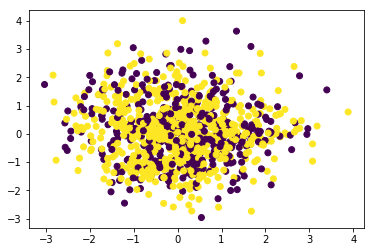

In [130]:
x = mu_latent[:, 0].data.cpu().numpy()
y = mu_latent[:, 1].data.cpu().numpy()

x_std = list(np.round(np.exp(logvar_latent[:, 0].mul(0.5).exp().data.cpu().numpy()), 2)**2)
y_std = list(np.round(np.exp(logvar_latent[:, 1].mul(0.5).exp().data.cpu().numpy()), 2)**2)

plt.scatter(x, y, c=dataset.assignment_data)
# plt.errorbar(x[:10], y[:10], yerr=y_std[:10], xerr=x_std[:10])
plt.show()


### Data Processing

In [7]:
assignment_model_names = ['A_add_lin', 'B_add_mild_nlin', 'C_add_mod_nlin', 'D_mild_nadd_lin',
                     'E_mild_nadd_mild_nlin', 'F_mod_nadd_lin', 'G_mod_nadd_mod_nlin']

for dataset_number in range(90, 100):
    print("Starting run for Dataset {}".format(dataset_number))
    
    for model_name in assignment_model_names:
        print("-- Running for model name: ", model_name)
        
        start = time()

        dataset = CovariateDataset("n_{}_model_{}_v_{}_covar_data", [1000, model_name, dataset_number])

        trained_model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent = \
            train_model(ModifiedVAE, dataset, dataset_number,verbose=True)

        encode_data(trained_model, dataset)

        print("---- Done in ", time() - start, " seconds\n")
                
    print("================\n\n")

Starting run for Dataset 90
-- Running for model name:  A_add_lin
====> Epoch: 1000 Average loss: 0.00268768
====> Epoch: 2000 Average loss: 0.00237313
====> Epoch: 3000 Average loss: 0.00224286
====> Epoch: 4000 Average loss: 0.00217269
====> Epoch: 5000 Average loss: 0.00208389
====> Epoch: 6000 Average loss: 0.00200424
====> Epoch: 7000 Average loss: 0.00197165
====> Epoch: 8000 Average loss: 0.00194840
====> Epoch: 9000 Average loss: 0.00185654
====> Epoch: 10000 Average loss: 0.00185729
Training state:  False
---- Done in  84.95870208740234  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 1000 Average loss: 0.00287928
====> Epoch: 2000 Average loss: 0.00241111
====> Epoch: 3000 Average loss: 0.00213923
====> Epoch: 4000 Average loss: 0.00215906
====> Epoch: 5000 Average loss: 0.00196259
====> Epoch: 6000 Average loss: 0.00191134
====> Epoch: 7000 Average loss: 0.00185074
====> Epoch: 8000 Average loss: 0.00185662
====> Epoch: 9000 Average loss: 0.00182047
====> E

====> Epoch: 1000 Average loss: 0.00284964
====> Epoch: 2000 Average loss: 0.00255731
====> Epoch: 3000 Average loss: 0.00242743
====> Epoch: 4000 Average loss: 0.00237298
====> Epoch: 5000 Average loss: 0.00233932
====> Epoch: 6000 Average loss: 0.00232236
====> Epoch: 7000 Average loss: 0.00225559
====> Epoch: 8000 Average loss: 0.00225023
====> Epoch: 9000 Average loss: 0.00224519
====> Epoch: 10000 Average loss: 0.00221983
Training state:  False
---- Done in  84.03732299804688  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 1000 Average loss: 0.00272160
====> Epoch: 2000 Average loss: 0.00235737
====> Epoch: 3000 Average loss: 0.00233571
====> Epoch: 4000 Average loss: 0.00221473
====> Epoch: 5000 Average loss: 0.00226114
====> Epoch: 6000 Average loss: 0.00216919
====> Epoch: 7000 Average loss: 0.00211925
====> Epoch: 8000 Average loss: 0.00205293
====> Epoch: 9000 Average loss: 0.00198881
====> Epoch: 10000 Average loss: 0.00197461
Training state:  False
---- Do

====> Epoch: 1000 Average loss: 0.00317736
====> Epoch: 2000 Average loss: 0.00298828
====> Epoch: 3000 Average loss: 0.00294221
====> Epoch: 4000 Average loss: 0.00291144
====> Epoch: 5000 Average loss: 0.00288035
====> Epoch: 6000 Average loss: 0.00285088
====> Epoch: 7000 Average loss: 0.00281545
====> Epoch: 8000 Average loss: 0.00285385
====> Epoch: 9000 Average loss: 0.00280671
====> Epoch: 10000 Average loss: 0.00279417
Training state:  False
---- Done in  93.21560001373291  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 1000 Average loss: 0.00285003
====> Epoch: 2000 Average loss: 0.00242106
====> Epoch: 3000 Average loss: 0.00230542
====> Epoch: 4000 Average loss: 0.00213527
====> Epoch: 5000 Average loss: 0.00204583
====> Epoch: 6000 Average loss: 0.00200030
====> Epoch: 7000 Average loss: 0.00194190
====> Epoch: 8000 Average loss: 0.00189005
====> Epoch: 9000 Average loss: 0.00185654
====> Epoch: 10000 Average loss: 0.00184931
Training state:  False
---- D

====> Epoch: 1000 Average loss: 0.00292306
====> Epoch: 2000 Average loss: 0.00272235
====> Epoch: 3000 Average loss: 0.00264855
====> Epoch: 4000 Average loss: 0.00253912
====> Epoch: 5000 Average loss: 0.00247762
====> Epoch: 6000 Average loss: 0.00251480
====> Epoch: 7000 Average loss: 0.00242523
====> Epoch: 8000 Average loss: 0.00239897
====> Epoch: 9000 Average loss: 0.00238141
====> Epoch: 10000 Average loss: 0.00233883
Training state:  False
---- Done in  95.20706605911255  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 1000 Average loss: 0.00322684
====> Epoch: 2000 Average loss: 0.00277094
====> Epoch: 3000 Average loss: 0.00254486
====> Epoch: 4000 Average loss: 0.00240701
====> Epoch: 5000 Average loss: 0.00235318
====> Epoch: 6000 Average loss: 0.00231776
====> Epoch: 7000 Average loss: 0.00221853
====> Epoch: 8000 Average loss: 0.00218643
====> Epoch: 9000 Average loss: 0.00218974
====> Epoch: 10000 Average loss: 0.00214288
Training state:  False


====> Epoch: 1000 Average loss: 0.00280285
====> Epoch: 2000 Average loss: 0.00240544
====> Epoch: 3000 Average loss: 0.00212776
====> Epoch: 4000 Average loss: 0.00199745
====> Epoch: 5000 Average loss: 0.00194268
====> Epoch: 6000 Average loss: 0.00197092
====> Epoch: 7000 Average loss: 0.00188999
====> Epoch: 8000 Average loss: 0.00181875
====> Epoch: 9000 Average loss: 0.00183391
====> Epoch: 10000 Average loss: 0.00180639
Training state:  False
---- Done in  102.99099206924438  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 1000 Average loss: 0.00344108
====> Epoch: 2000 Average loss: 0.00301006
====> Epoch: 3000 Average loss: 0.00289821
====> Epoch: 4000 Average loss: 0.00275760
====> Epoch: 5000 Average loss: 0.00268710
====> Epoch: 6000 Average loss: 0.00266223
====> Epoch: 7000 Average loss: 0.00261958
====> Epoch: 8000 Average loss: 0.00260639
====> Epoch: 9000 Average loss: 0.00252550
====> Epoch: 10000 Average loss: 0.00248503
Training state:  False
---- D

In [8]:
models_to_rerun = [('A_add_lin', 12, 'sparsity'), ('G_mod_nadd_mod_nlin', 40, 'sparsity')]

for model_name, dataset_number, loss_type in models_to_rerun:
    dataset = CovariateDataset("n_{}_model_{}_v_{}_covar_data", [1000, model_name, dataset_number])
    trained_model, final_loss = train_model(
                                        autoencoder,
                                        dataset,
                                        loss=loss_type,
                                        verbose=True)
    encode_data(trained_model, dataset, loss=loss_type)

epoch [1000/10000], loss:0.4875
epoch [2000/10000], loss:0.4456
epoch [3000/10000], loss:0.4104
epoch [4000/10000], loss:0.3195
epoch [5000/10000], loss:0.3145
epoch [6000/10000], loss:0.3127
epoch [7000/10000], loss:0.3118
epoch [8000/10000], loss:0.3107
epoch [9000/10000], loss:0.3096
epoch [10000/10000], loss:0.3084
Final loss: loss:0.3084
epoch [1000/10000], loss:0.5869
epoch [2000/10000], loss:0.5415
epoch [3000/10000], loss:0.5173
epoch [4000/10000], loss:0.4197
epoch [5000/10000], loss:0.4216
epoch [6000/10000], loss:0.4136
epoch [7000/10000], loss:0.4132
epoch [8000/10000], loss:0.4127
epoch [9000/10000], loss:0.4123
epoch [10000/10000], loss:0.4118
Final loss: loss:0.4118
